In [2]:
# necessary imports

from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model
from langchain.tools.retriever import create_retriever_tool
from typing import List

from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import MessagesState
from langchain.chat_models import init_chat_model

from pydantic import BaseModel, Field
from typing import Literal

In [ ]:


def multiply(a: float, b:float) -> float:
    """
    Tool to be used when needed to multiply two numbers togehter.
    """
    return a * b



def add(a: float, b:float) -> float:
    """
    Tool to be used when needed to add two numbers.
    """
    return a + b


def talk(text: str) -> str:
    """
    Tool to be used when the other tools are not suitable to be used. 
    """

    response = (llm_model.invoke(text))
    return response


# defining our LLM-models for response
llm_model = ChatOllama(model = "llama3.2", temperature=0)


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to use any of the tools, or simply respond to the user.
    """
    response = (
        llm_model.bind_tools([multiply, add, talk]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [3]:
#input = {"messages": [{"role": "user", "content": "hello! how are you doing?"}]}
#generate_query_or_respond(input)["messages"][-1].pretty_print()

In [4]:
EVALUATE_PROMPT = ("You are an assistant that is responsible for verifying results. "
                    "Your function is not to calculate the values for the response, but rather just confirm that the answer is correct."
                    "You can use these tools to confirm the solutions: {multiply} and {addition}")


class GradeResponse(BaseModel):
    """Grade results using a binary score for accuracy in values of response."""

    binary_score: str = Field(
        description="Correctness score: 'yes' if correct, or 'no' if wrong"
    )


def evaluate_results(state: MessagesState):
    """
    Tool responsible for evaluating the quality of the calculations of the tools used.
    """

    prompt = EVALUATE_PROMPT.format(multiply, add)
    response = llm_model.with_structured_output(GradeResponse).invoke( [{"role": "user", "content": prompt}])
    score = response.binary_score

    if score == 'yes':
        return 'correct'
    else:
        return 'wrong'

In [5]:
RECALCULATE_PROMPT = (
    "Look at the input and try to once again use the tools to correctly calculate the result" \
    "Once again these are the tools available to use: {multiplication} and {addition}" \
    "It might be needed only one operation or more than one."
)

def recalculate(state: MessagesState):
    """Rewrite the original user question."""
    prompt = RECALCULATE_PROMPT.format(multiply, add)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}



In [6]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm_model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

# Assemble Graph

In [24]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("multiply", ToolNode([multiply]))
workflow.add_node("addition", ToolNode([add]))
workflow.add_node("talk", ToolNode([talk]))
workflow.add_node(evaluate_results)
workflow.add_node(recalculate)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "multiplication": "multiply",
        "add" : "addition",
        "talk more": "talk",
    },
)




workflow.add_edge("recalculate", "generate_query_or_respond")
workflow.add_edge("multiply", "evaluate_results")
workflow.add_edge("addition", "evaluate_results")
workflow.add_edge("talk", "evaluate_results")


workflow.add_conditional_edges(
    "evaluate_results",
    # Assess agent decision
    evaluate_results,
    {
        "recalculate": "recalculate",
        "generate_answer": "generate_answer"
    }
)

workflow.add_edge("generate_answer", END)



# Compile
graph = workflow.compile()

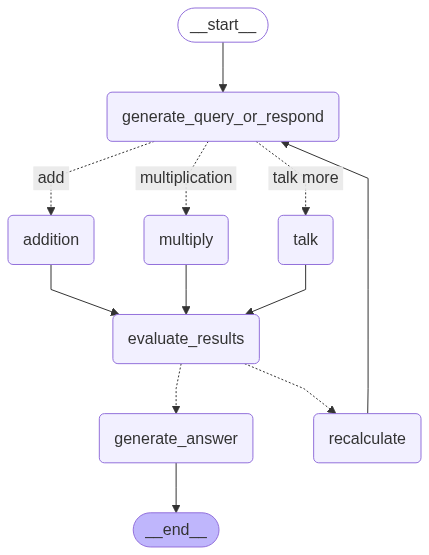

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "How much is 3 + 3 and how much is 2 x 5?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

KeyError: 'tools'